In [1]:
import numpy as np
import networkx as nx
from edge_fetch import edge_terrier
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import normalize
from featureAnalysis import featureSelection
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

In [2]:
#Load Edgelists

# Initialize edgelist collector object
graph_collector = edge_terrier('/Users/paigefrank/Library/Python/3.6/bin/aws', 1 , filepath='hbn/derivatives/graphs/JHU/')
# Make a generator that yields all edgelists in filepath
filelist = graph_collector.convert_edgelist_all()
# Get a list of just the network x objects
graphList = graph_collector.getGraphs(filelist)

sub-NDARDX770PJK_acq-64dir_dwi_JHU.edgelist is empty.


In [55]:
#Output feature matrix to a file

#D = num graphs, m = eigenvector centrality values
featureObj = featureSelection(graphList)
X = featureObj.eigenvectorCentrality(numFeatures = 3)
mat = np.matrix(X, dtype = float)
with open('outfileMat.txt','wb') as f:
    for line in mat:
        np.savetxt(f, line, fmt='%.2f')
print("Feature matrix of shape", mat.shape, "outputted. Run Urerf in R now.")

Feature matrix of shape (97, 3) outputted. Run Urerf in R now.


In [56]:
#Load Urerf Similarity matrix from file

matrix = open('outfileSimMat.txt').read()
matrix = [item.split() for item in matrix.split('\n')[:-1]]
inputMat = np.matrix(matrix, dtype = float)

In [57]:
#Cluster with affinity Propogation for multiple parameters


preproc = 0
for i in range(1, 10):
    #vary the preference value
    preproc = preproc + .05
    for j in range(5, 10):
        #vary the damping value
        damp = .1 * j
        af = AffinityPropagation(damping = damp, preference = preproc,affinity="precomputed").fit(inputMat)
        cluster_centers_indices = af.cluster_centers_indices_
        labels = af.labels_
        n_clusters = len(cluster_centers_indices)
        ss = silhouette_score(inputMat, labels)
        print('|Preference |% 1.2f' % preproc, "| Damping | % 1.1f" % damp,"| Clusters | ", n_clusters, "| Silhouette | % 1.3f" % ss, "|")
        

|Preference | 0.05 | Damping |  0.5 | Clusters |  26 | Silhouette |  0.393 |
|Preference | 0.05 | Damping |  0.6 | Clusters |  26 | Silhouette |  0.393 |
|Preference | 0.05 | Damping |  0.7 | Clusters |  25 | Silhouette |  0.381 |
|Preference | 0.05 | Damping |  0.8 | Clusters |  25 | Silhouette |  0.381 |
|Preference | 0.05 | Damping |  0.9 | Clusters |  27 | Silhouette |  0.284 |
|Preference | 0.10 | Damping |  0.5 | Clusters |  25 | Silhouette |  0.381 |
|Preference | 0.10 | Damping |  0.6 | Clusters |  26 | Silhouette |  0.393 |
|Preference | 0.10 | Damping |  0.7 | Clusters |  26 | Silhouette |  0.393 |
|Preference | 0.10 | Damping |  0.8 | Clusters |  26 | Silhouette |  0.407 |
|Preference | 0.10 | Damping |  0.9 | Clusters |  19 | Silhouette |  0.204 |
|Preference | 0.15 | Damping |  0.5 | Clusters |  26 | Silhouette |  0.407 |
|Preference | 0.15 | Damping |  0.6 | Clusters |  26 | Silhouette |  0.407 |
|Preference | 0.15 | Damping |  0.7 | Clusters |  26 | Silhouette |  0.407 |

In [34]:
#isolate best clustering output and create a sorted similarity matrix
af = AffinityPropagation(damping = 0.6, preference = 0.35,affinity="precomputed").fit(inputMat)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
n_clusters = len(cluster_centers_indices)
#create a dictionary of labels and nodes
nodeDict = dict(enumerate(labels))
#sort the nodes so that they are grouped by cluster label
s = sorted(nodeDict, key=nodeDict.get)
#create a sorted similarity matrix
sortedSimMat = np.empty((len(s), len(s)))
for i in range(0, len(s)):
    node = s[i]
    for j in range(0, len(s)):
        sortedSimMat[i][j] = inputMat[node, j]

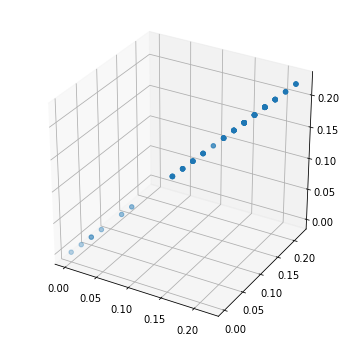

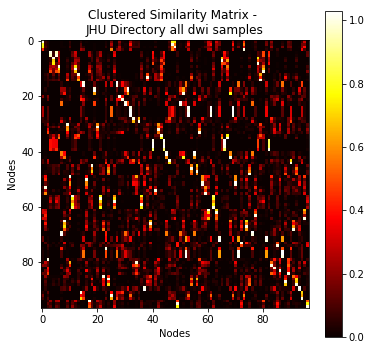

In [53]:
#create a heat map of the sorted similarity matrix
plt.figure(2)
im = plt.imshow(sortedSimMat, cmap='hot', interpolation='nearest')
cbar = plt.colorbar(im) 
plt.xlabel('Nodes')
plt.ylabel('Nodes')
plt.title("Clustered Similarity Matrix - \nJHU Directory all dwi samples")
plt.show()